## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Оглавление
[1. Подготовка данных](#section_1)<br>
[2. Обучение](#section_2)<br>
[3. Анализ](#section_3)<br>
[4. Тестирование](#section_3)<br>

<a id='section_1'><h1>1. Подготовка данных</h1></a>

##### 1.1. Загрузим необходимые библиотеки

In [1]:
#Загрузим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import fbeta_score, make_scorer
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

##### 1.2. Получим информацию о данных

In [2]:
data=pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


##### 1.3. Ресемплирование данных

In [5]:
data.sort_index(inplace=True)
data = data.resample('1h').sum()

<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка данных, их первичный осмотр и ресемплинг проведены корректно.
</div>

<a id='section_2'><h1>2. Анализ</h1></a>

##### 2.1. Проверка расположения данных в хронологическом порядке

In [6]:
print('Данные расположены в хронологическом порядке:', data.index.is_monotonic)

Данные расположены в хронологическом порядке: True


##### 2.2. Построение графика временного ряда

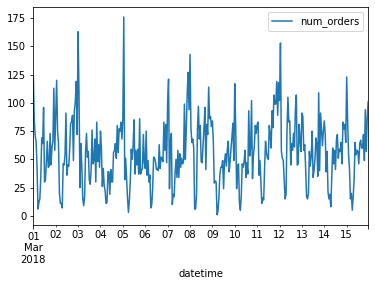

In [7]:
data['2018-03-01':'2018-03-15'].plot()

##### 2.3. Построение графика сезонности

In [8]:
decomposed = seasonal_decompose(data)

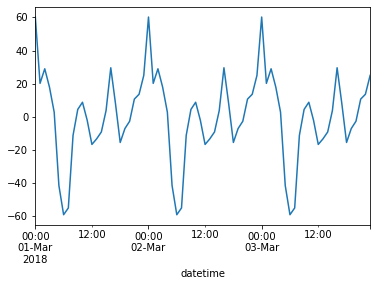

In [9]:
#Построим график заказов за 3 дня
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())

На графике видно, что самое большое количество заказов происходит в районе 00:00 часов.

##### 2.4. Построение графика тренда

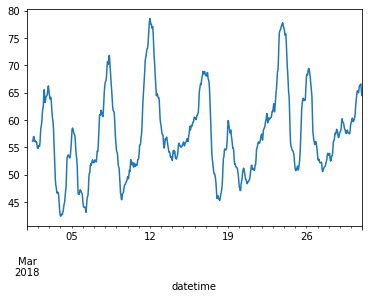

In [10]:
decomposed.trend['2018-03-01':'2018-03-30'].plot(ax=plt.gca())

По графику видно, что к концу марта заказов станвится больше

<div class="alert alert-block alert-success">
<b>Успех:</b> График сезонности получился хорошо. Можно было еще заметить дневную сезонность.
</div>

##### 2.3. Построение графика скользящего среднего и стандартного отклонения по скользящему окну

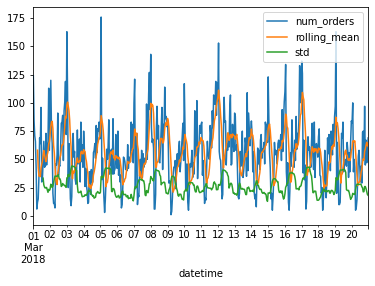

In [11]:
data['rolling_mean'] = data['num_orders'].rolling(7).mean()
data['std'] = data['num_orders'].rolling(15).std()
data['2018-03-01':'2018-03-20'].plot()

По этому графику можно сделать вывод, что данный нам временной ряд является стационарным. Так как у него с течением времени не меняется стандартное отклонение и скользящее среднее

<a id='section_3'><h1>3. Обучение</h1></a>

##### 3.1. Создание новых признаков

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean_shift'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['std_shift'] = data['num_orders'].shift().rolling(rolling_mean_size).std()

In [13]:
make_features(data, 3,3)

##### 3.2. Создание тестовой и обучающей выборки

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
features_train = train.drop(['num_orders', 'rolling_mean', 'std'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders','rolling_mean', 'std'], axis=1)
target_test = test['num_orders']


##### 3.3. Модель линейной регрессии

In [16]:
model_linear=LinearRegression()
param_grid = { 
    'normalize': ['True', 'False'],
    }

In [17]:
CV_lr = GridSearchCV(estimator=model_linear, param_grid=param_grid, cv= TimeSeriesSplit(n_splits=3).split(features_train))
CV_lr.fit(features_train, target_train)
CV_lr.best_params_

{'normalize': 'True'}

In [18]:
model_linear=LinearRegression(normalize=True)
model_linear.fit(features_train, target_train)
predictions_train = model_linear.predict(features_train) 
predictions_test = model_linear.predict(features_test)
RMSE_linear = (mean_squared_error(target_train, predictions_train))**0.5
print('{:.2f}'.format(RMSE_linear))

30.40


Вывод:Лучшая RMSE линейной регрессии: 30.40. 

##### 3.4. Модель случайного леса

In [19]:
model_forest=RandomForestRegressor(random_state=42)
param_grid = { 
    'n_estimators': [100, 150],
    'max_depth' : [10,11,12,13,14,15,20],
    }

In [20]:
%%time
CV_rfr = GridSearchCV(estimator=model_forest, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=3).split(features_train))
CV_rfr.fit(features_train, target_train)
CV_rfr.best_params_

Wall time: 41.3 s


{'max_depth': 20, 'n_estimators': 150}

In [21]:
model_forest=RandomForestRegressor(random_state=42, max_depth=20, n_estimators=150)
model_forest.fit(features_train, target_train)
model_forest_prediction = model_forest.predict(features_train)
RMSE_forest = (mean_squared_error(target_train, model_forest_prediction))**0.5
print('{:.2f}'.format(RMSE_forest))

8.59


Вывод:Лучшая RMSE Случайного леса: 8.59. Гиперпараметры max_depth=20, n_estimators=150

##### 3.5. Модель дерева решений

In [22]:
model_tree = DecisionTreeRegressor(random_state=0)
param_grid = { 
    'max_depth' : [10,11,12,13,14,15,16,17,18,19,20],
    }

In [23]:
%%time
CV_fr = GridSearchCV(estimator=model_tree, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=3).split(features_train))
CV_fr.fit(features_train, target_train)
CV_fr.best_params_

Wall time: 578 ms


{'max_depth': 10}

In [24]:
%%time
model_tree = DecisionTreeRegressor(random_state=0, max_depth=10)
model_tree.fit(features_train, target_train)
model_tree_prediction = model_tree.predict(features_train)
RMSE_tree = (mean_squared_error(target_train, model_tree_prediction))**0.5
print('{:.2f}'.format(RMSE_tree))

16.89
Wall time: 21.9 ms


Вывод:Лучшая RMSE решающего дерева: 16.89. Гиперпараметры max_depth=10

##### 3.6. Градиентный бустинг

In [25]:
model_LGBM=LGBMRegressor()
param_grid = { 
    'n_estimators': [100, 150],
    'max_depth' : [10,11,12,13,14,15,20],
    'num_leaves' : [100]
    }

In [26]:
%%time
CV_LGBM = GridSearchCV(estimator=model_LGBM, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=3).split(features_train))
CV_LGBM.fit(features_train, target_train)
CV_LGBM.best_params_

Wall time: 3.62 s


{'max_depth': 14, 'n_estimators': 100, 'num_leaves': 100}

In [27]:
%%time
model_LGBM = LGBMRegressor(max_depth=14, n_estimators=100, num_leaves=100)
model_LGBM.fit(features_train, target_train)
model_LGBM_prediction = model_LGBM.predict(features_train)
RMSE_LGBM = (mean_squared_error(target_train, model_LGBM_prediction))**0.5
print('{:.2f}'.format(RMSE_LGBM))

11.42
Wall time: 132 ms


Вывод:Лучшая RMSE градиентного бустинга: 11.24. Гиперпараметры max_depth=14, n_estimators=100, num_leaves=100

<a id='section_4'><h1>4. Тестирование</h1></a>

##### 4.1. Модель линейной регрессии

In [28]:
model = LinearRegression(normalize=True)
model.fit(features_train, target_train)
predictions_train = model.predict(features_train) 
predictions_test = model.predict(features_test)

In [29]:
RMSE_linear = (mean_squared_error(target_test, predictions_test))**0.5
print('{:.2f}'.format(RMSE_linear))

52.36


##### 3.4. Модель случайного леса

In [30]:
%%time
model_forest = RandomForestRegressor(random_state=0, max_depth=20, n_estimators=150)
model_forest.fit(features_train, target_train)
model_forest_prediction = model_forest.predict(features_test)
RMSE_forest = (mean_squared_error(target_test, model_forest_prediction))**0.5
print('{:.2f}'.format(RMSE_forest))

48.35
Wall time: 2.41 s


##### 3.5. Модель дерева решений

In [31]:
%%time
model_tree = DecisionTreeRegressor(random_state=0, max_depth=10)
model_tree.fit(features_train, target_train)
model_tree_prediction = model_tree.predict(features_test)
RMSE_tree = (mean_squared_error(target_test, model_tree_prediction))**0.5
print('{:.2f}'.format(RMSE_tree))

55.78
Wall time: 24.9 ms


##### 3.6. Градиентный бустинг

In [32]:
%%time
model_LGBM = LGBMRegressor(max_depth=14, n_estimators=100, num_leaves=100)
model_LGBM.fit(features_train, target_train)
model_LGBM_prediction = model_LGBM.predict(features_test)
RMSE_LGBM = (mean_squared_error(target_test, model_LGBM_prediction))**0.5
print('{:.2f}'.format(RMSE_LGBM))

45.96
Wall time: 109 ms


<strong>Вывод</strong>:Мы проанализировали почасовое количество заказов такси. Были выделены распределения заказов за сутки, построены тренды и выявленав сезонность заказов. Далее были построены модели для прогнозирования заказов. Лучшей моделью оказалась модель градиентного бустинга. Её RMSE равна 45.96, при достаточно небольшом времени обучения. 